In [42]:
import numpy as np
np.set_printoptions(precision=2)

room_temp = 18.333
side_length = 11
pan_temp = room_temp
oven_temp = 162.778
brownie_target = 85

h = 9.14
A = 0.0001 # approx 0.01m ^2, 5.208 degree slice

brownie_density = 500
brownie_specific_heat = 2550
brownie_conductivity = 0.15 * 3
brownie_alpha = brownie_conductivity / (brownie_density * brownie_specific_heat)

steel_density = 7832
steel_specific_heat = 434
steel_conductivity = 59
steel_alpha = steel_conductivity / (steel_density * steel_specific_heat)

print(brownie_alpha)
print(steel_alpha)

def initialize_brownie_slice(side_length, room_temp):
    return np.full(side_length, room_temp)


3.529411764705882e-07
1.7357597096632978e-05


In [43]:
brownie_slice = initialize_brownie_slice(side_length, room_temp)

def heat_transfer_over_increment(brownie_slice: np.array, pan_temp, dr, dt):
    # oven to pan
    d_pan_temp = h * A * (oven_temp - pan_temp)
    pan_temp += dt * d_pan_temp 

    # pan to brownie
    time_derivative = np.zeros(brownie_slice.shape)
    for i, temp in enumerate(brownie_slice):
        if i == 0:
            outside_neighbour = brownie_slice[i+1]
            inside_neighbour = temp
        elif i == side_length - 1:
            outside_neighbour = pan_temp
            inside_neighbour = brownie_slice[i-1]
        else:
            outside_neighbour = brownie_slice[i-1]
            inside_neighbour = brownie_slice[i+1]

        r = i + 0.5
        first_term = (r-.5) * ((inside_neighbour - temp) / dr) - ((r+0.5) * (temp - outside_neighbour) / dr)
        first_term += (pan_temp * r)/dr
        time_derivative[i] = brownie_alpha * (1/r) * first_term * (1/dr)

    brownie_slice += (time_derivative * dt)
    
    return brownie_slice, pan_temp

In [44]:
brownie_slice = initialize_brownie_slice(side_length, room_temp)
counter = 0
while True:
    brownie_slice, pan_temp = heat_transfer_over_increment(brownie_slice, pan_temp, dr=0.02, dt=0.01) # 0.01 meters (1cm), 0.01 seconds
    counter += 1
    # if counter % 10000 == 0:
      # print(brownie_slice)
    if brownie_slice[0] >= brownie_target:

        print(f"{counter / 100 / 60} minutes of cooking")
        break

print(brownie_slice)

17.831333333333337 minutes of cooking
[85.   85.   85.   85.   85.   85.   85.02 85.15 85.85 88.97 98.4 ]


In [45]:
import math

cooked_baseline = np.full(side_length, brownie_target + 3)

over_cooked = brownie_slice - cooked_baseline
over_cooked = over_cooked.clip(min=0)
# avg_error = (np.sum(over_cooked) * (22 * math.pi)) / (math.pi * side_length**2)

avg_error = np.sum(over_cooked) / 11

print(avg_error)

1.033166866297293


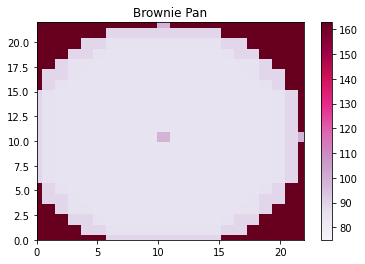

In [46]:
import matplotlib.pyplot as plt
import numpy as np
import math

# convert 1D array into circle
brownie_pan = np.full((side_length*2, side_length*2), oven_temp)
radius = side_length
# for x in range(side_length-1, 2*side_length):
#     for y in range(side_length-1, 2*side_length):
for x in range(2*side_length):
    for y in range(2*side_length):
        dist_from_center = math.sqrt(((x+1) - radius)**2 + ((y+1)-radius)**2)
        if dist_from_center <= side_length:
            brownie_pan[x][y] = brownie_slice[int(dist_from_center - 1)]

# generate 2 2d grids for the x & y bounds
y, x = np.meshgrid(np.linspace(0, side_length*2, side_length*2), np.linspace(0, side_length*2, side_length*2))

# z = (1 - x / 2. + x ** 5 + y ** 3) * np.exp(-x ** 2 - y ** 2)
# # x and y are bounds, so z should be the value *inside* those bounds.
# # Therefore, remove the last value from the z array.
# z = z[:-1, :-1]
z = brownie_pan
z_min, z_max = 75, np.abs(z).max()

fig, ax = plt.subplots()

c = ax.pcolormesh(x, y, z, cmap='PuRd', vmin=z_min, vmax=z_max, shading='auto')
ax.set_title('Brownie Pan')
# set the limits of the plot to the limits of the data
ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax)

plt.show()